# Preprocessing

<b>Import Libs</b>

In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet 
import matplotlib.pyplot as plt
 
%matplotlib inline

plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

<b>Read *csv file</b>

In [2]:
f= open('API data/GAZP.csv', 'r')
raw_data = f.read().split(',')

data = []
temporary = []

for i, v in enumerate(raw_data, 1):
    temporary.append(v)
    
    if i % 3 == 0:
        data.append(temporary)
        temporary = []

<b>Make DF and preprocessing data</b>

In [3]:
df = pd.DataFrame(columns=['date', 'open', 'close'], data=data)
df.drop(df[df['close'] == 'None'].index, inplace=True)
df = df.reset_index(drop=True)

df = df.rename(columns={'close': 'y', 'date': 'ds'})
df = df.drop(columns=['open'])

df['ds'] = pd.to_datetime(df['ds'])
df['y'] = df['y'].astype('float')

df['y_18'] = df.iloc[:,1].rolling(window=18).mean().round(2)
df['y_50'] = df.iloc[:,1].rolling(window=50).mean().round(2)

display(df.tail())
df.info()

,ds,y,y_18,y_50
1371,2023-06-16,169.87,164.94,172.75
1372,2023-06-19,170.19,165.14,172.68
1373,2023-06-20,169.64,165.51,172.64
1374,2023-06-21,170.20,165.95,172.58
1375,2023-06-22,168.41,166.17,172.46


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1376 entries, 0 to 1375
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1376 non-null   datetime64[ns]
 1   y       1376 non-null   float64       
 2   y_18    1359 non-null   float64       
 3   y_50    1327 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 43.1 KB


# Let's Start Prophet

<b>Look at the data</b>

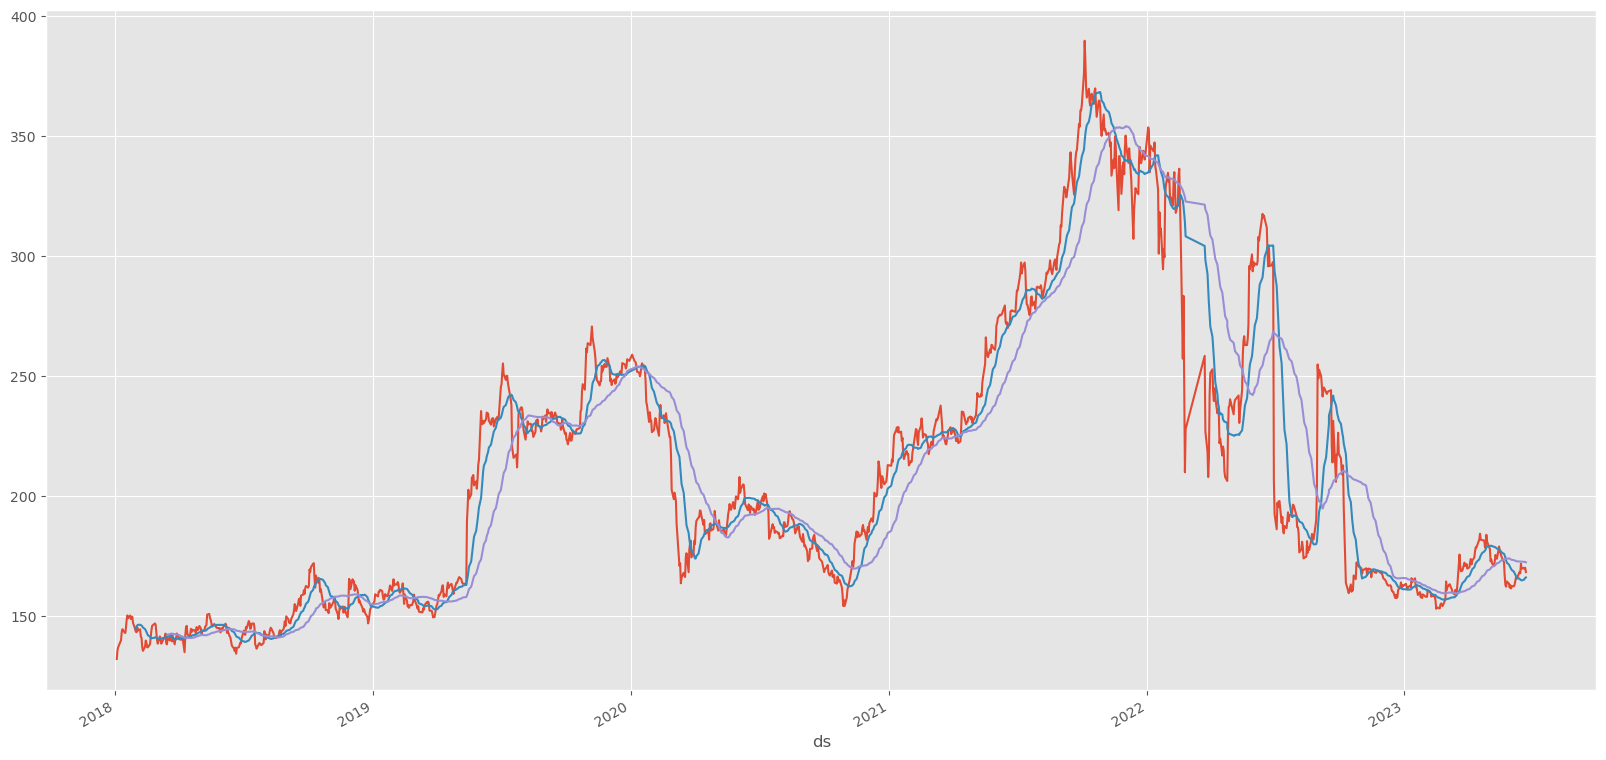

In [4]:
df.set_index('ds').y.plot()
df.set_index('ds').y_18.plot()
df.set_index('ds').y_50.plot()

**Running Prophet**

12:00:44 - cmdstanpy - INFO - Chain [1] start processing
12:00:44 - cmdstanpy - INFO - Chain [1] done processing


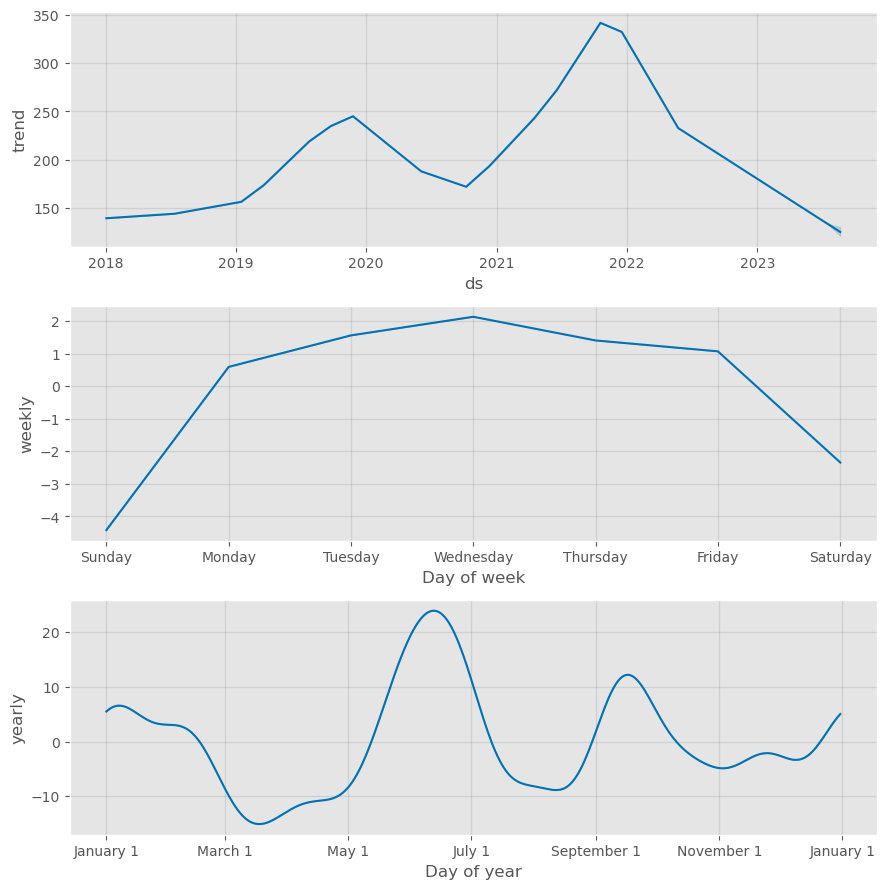

In [5]:
model = Prophet()
model.fit(df)

# Added (AM: changed to 30 days [23.06.2023])
future = model.make_future_dataframe(periods=30, freq = 'd')
#future.tail()

#model.fit(df)
forecast = model.predict(future)
fig = model.plot_components(forecast)

In [6]:
forecast = model.predict(future)

In [7]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1418,2023-08-17,118.974526,96.413678,142.452561
1419,2023-08-18,118.628883,96.395673,140.377769
1420,2023-08-19,115.266552,93.062859,139.779952
1421,2023-08-20,113.305583,89.817453,136.405277
1422,2023-08-21,118.500955,95.788908,142.682204


<b>Plotting</b>

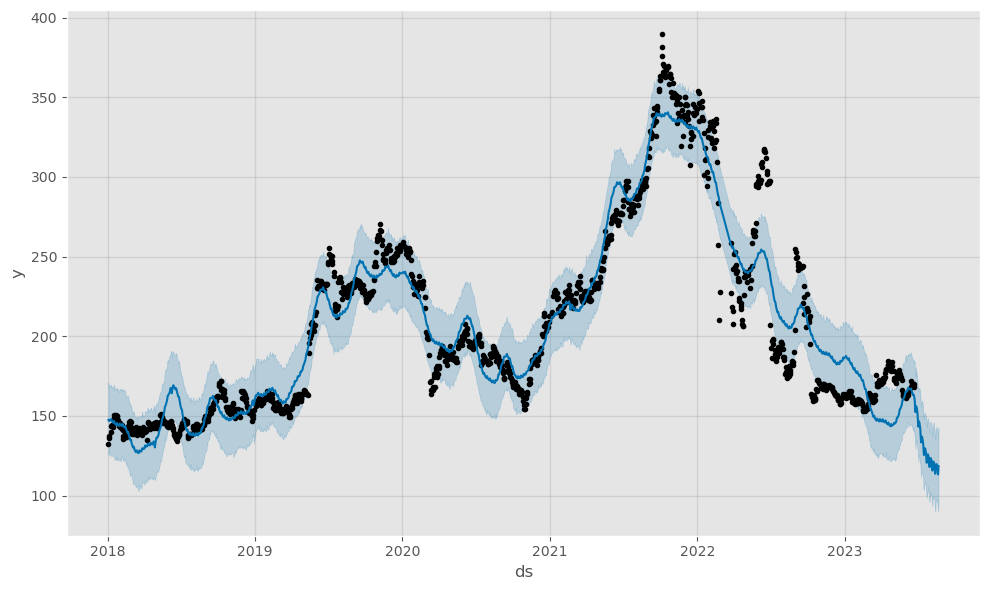

In [8]:
model.plot(forecast);

<b>Visualizing Prophet models</b>

In [9]:
df.set_index('ds', inplace=True)
forecast.set_index('ds', inplace=True)

In [10]:
viz_df = df.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')

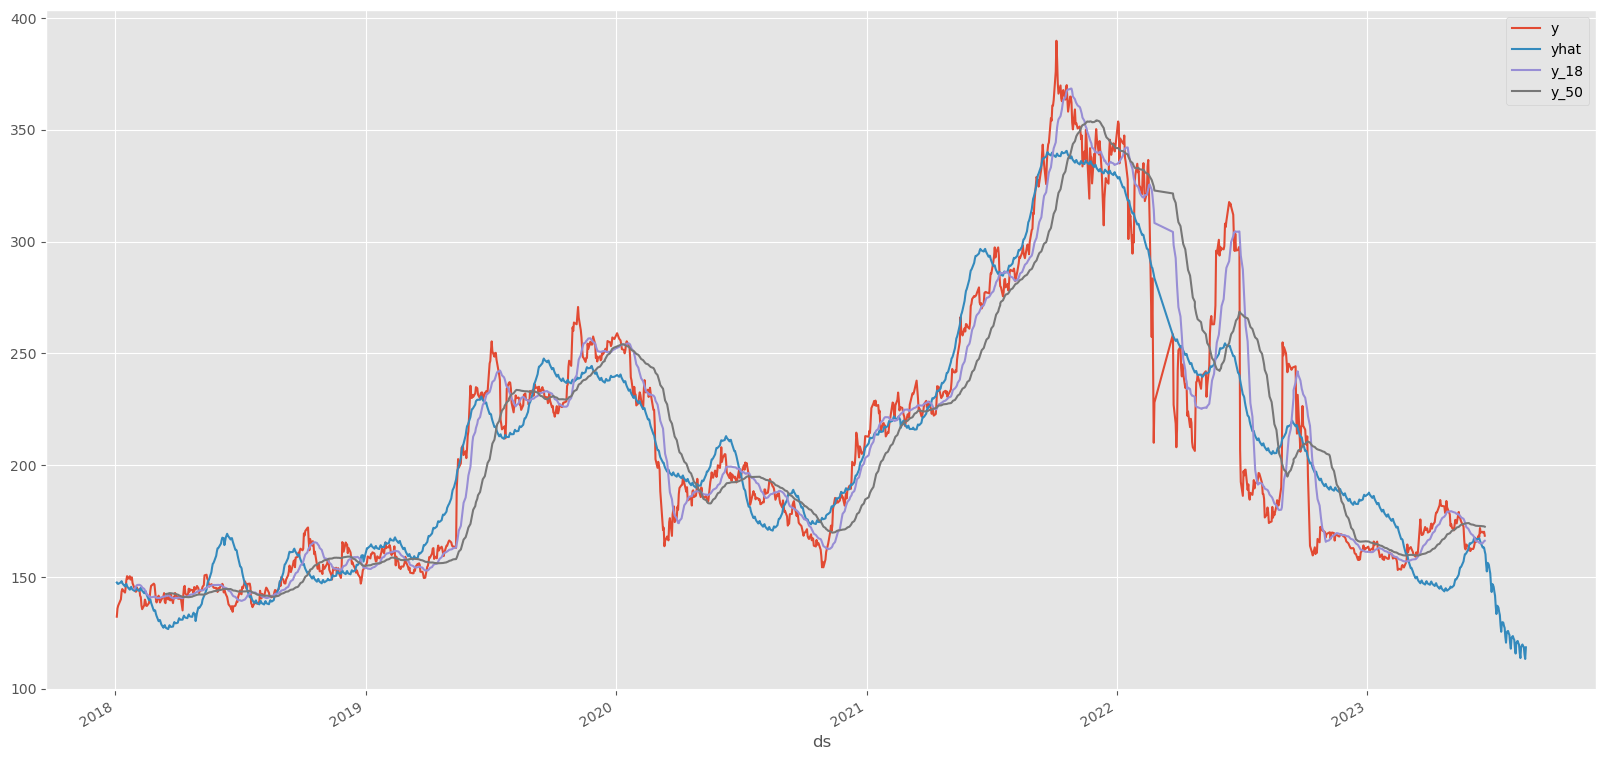

In [11]:
viz_df[['y', 'yhat','y_18','y_50']].plot()

<b> Saving project data in *xlsx</b>

In [12]:
viz_df.to_excel("GAZP_forecast.xlsx")  